In [1]:
# Before running this notebook, you need to specify the number of engines (cpus) to use.
# for example, I ran the following at the terminal:
#  ipcluster start -n 7

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division  # this makes mathematical division work better

myhome = '/home/viva'
datafolder = 'group/viva/Data'
data_date = '2016-01-26'
movienumber = '02'
moviename = '02_60x1.0_Hematite_swimmers_with_Lumencor_violet_100%'
filename = os.path.join(myhome, datafolder, data_date, moviename + '.avi')

darkcount_filename = os.path.join(myhome, datafolder, data_date, 'darkcount.avi')

filename

'/home/viva/group/viva/Data/2016-01-26/02_60x1.0_Hematite_swimmers_with_Lumencor_violet_100%.avi'

In [3]:
rawframes = pims.Video(filename, as_grey=True)
darkframes = pims.Video(darkcount_filename, as_grey=True)

# MacGruberscope 60x1.0
scaling = 150.0/1182.0  # microns per pixel, measured 2016-02-02
fps = 12.007 
frametime = 1000/fps    # milliseconds

bg_flag = False;   # the movie has not been backgrounded yet

In [4]:
import datetime
today = datetime.date.today().isoformat()

myanalysisfolder = 'group/viva/Analysis'
thismovieanalysisfolder = os.path.join(myhome, 
                                 myanalysisfolder, 
                                 today,
                                 'data_taken_' + data_date + ',_movie' + moviename)

thismovieanalysisfolder

'/home/viva/group/viva/Analysis/2016-02-26/data_taken_2016-01-26,_movie02_60x1.0_Hematite_swimmers_with_Lumencor_violet_100%'

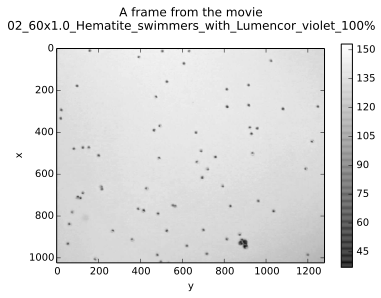

In [31]:
import holopy as hp
hp.show(rawframes[100])
plt.title('A frame from the movie\n' + moviename +'\n')

In [6]:
rawframes[0].shape

(1024, 1280)

In [7]:
#### Take a median average over frames of the darkcount movie.
df = np.median(darkframes,axis=0)

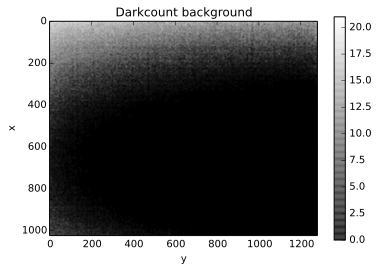

In [8]:
hp.show(df)
plt.title('Darkcount background')

In [9]:
del darkframes # clear some memory

In [10]:
#### Use the movie itself as brightfield background 
#### (not always advisable; it may be better if you take a 
#### separate brightfield background movie)
bg = np.median(rawframes,axis=0)

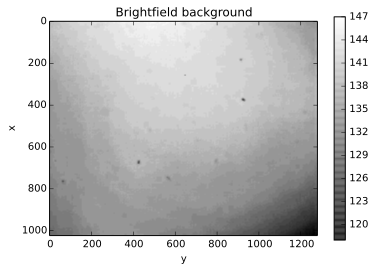

In [11]:
hp.show(bg)
plt.title('Brightfield background')

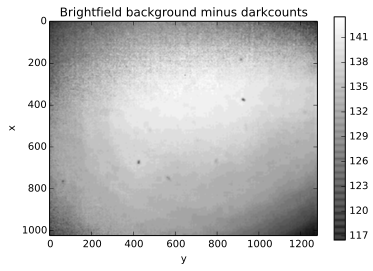

In [12]:
hp.show(bg-df)
plt.title('Brightfield background minus darkcounts')

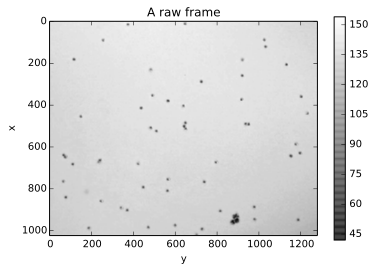

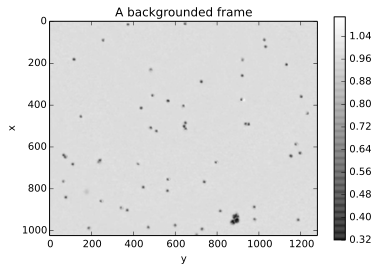

In [13]:
hp.show(rawframes[200])
plt.title('A raw frame')

hp.show((rawframes[200]-df)/(bg-df))
plt.title('A backgrounded frame')

In [ ]:
#### Background divide and subtract
if bg_flag == True:
    print 'Already backgrounded!'
else:
    #rawframes = frames
    #del frames
    try:
        time1 = time.time()
        frames = (rawframes-df)/(bg-df)  # background subtract and divide (slow)
        elapsed = time.time() - time1
        bg_flag = True;
        print('Backgrounded movie in ' + str(elapsed/60.0) + ' minutes.')
        del rawframes # clear memory
    except MemoryError:
        elapsed = time.time() - time1
        frames = rawframes
        print('Unable to background divide images after ' + str(elapsed/60.0) + ' minutes; not enough memory.')

hp.show(frames[100])
if bg_flag == True:
    plt.title('Backgrounded frame from movie')
else:
    plt.title('Frame from movie (not backgrounded)')

In [14]:
#### If not backgrounding, just rename the rawframes as frames.
frames = rawframes

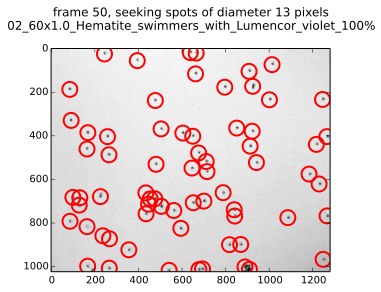

array([[<matplotlib.axes.AxesSubplot object at 0x7fd9a3785d90>,
        <matplotlib.axes.AxesSubplot object at 0x7fd9a34219d0>]], dtype=object)

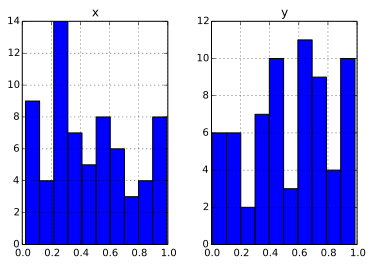

In [37]:
# find bright spots in a frame.
# featuresize must be odd.
# read up on this in the trackpy literature.
i = 50
featuresize = 13
plt.title('frame ' + str(i) + ', seeking spots of diameter ' 
          + str(featuresize) + ' pixels\n' + moviename +'\n')
f1 = tp.locate(frames[i], diameter=featuresize, invert=True, minmass=400)
tp.annotate(f1, frames[i])
tp.subpx_bias(f1)
#f1

In [40]:
# Following the recommendations of the trackpy walkthrough, I am using ipyparallel.

from ipyparallel import Client

client = Client()
view = client.load_balanced_view()

client.ids

[0, 1, 2, 3, 4, 5, 6]

In [18]:
curried_locate = lambda image: tp.locate(image, featuresize, invert=True, minmass=400)

In [20]:
%%px

import trackpy as tp

# The above will import trackpy again, but now with parallel processing.
# https://ipython.org/ipython-doc/3/parallel/magics.html

In [21]:
amr = view.map_async(curried_locate, frames[:100]) # take out the 100 if you want all frames
amr.wait_interactive()

 100/100 tasks finished after    0 s
done


In [22]:
time1 = time.time()
serial_result = list(map(curried_locate, frames[:100]))  # take out the 100 if you want all frames
elapsed = time.time() - time1
f_coords = pd.concat(serial_result, axis=0, join='outer')

print 'Found all coordinates in ' + str(elapsed/60.0) + ' minutes.'

Found all coordinates in 2.0807526509 minutes.


In [23]:
# tell me how many frames are in the movie
nframes = f_coords['frame'].max() - f_coords['frame'].min() + 1
nframes

100

In [24]:
# We have just built a list of coordinates called f_coords where we have seen particles. '
# Now we want to link these together from one frame to the next 
# so we can identify the trajectory for each particle.

# Documentation: http://soft-matter.github.io/trackpy/generated/trackpy.link_df.html

t = tp.link_df(features=f_coords, search_range=10, memory=3)
#t = pd.read_pickle('t.pkl')

# search_range gives the maximum distance features can move between frames. 
#              I think it's measured in pixels.
# memory gives the maximum number of frames during which a feature can vanish, 
#        then reappear nearby, and still be considered the same particle.
# This will run faster if the numba package is available.

Frame 99: 65 trajectories present


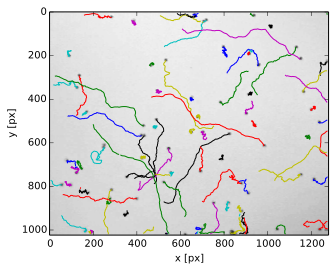

In [25]:
trajectory_plot = tp.plot_traj(t, superimpose = frames[0], label=False)

In [26]:
# only keep trajectories that last at least this many frames
t1 = tp.filter_stubs(t, 50)
# Compare the number of particles in the unfiltered and filtered data.
print 'Before:', t['particle'].nunique()
print 'After:', t1['particle'].nunique()

Before: 109
After: 66


In [27]:
tracks = t1['particle'].astype(int).unique()

print size(tracks)

66


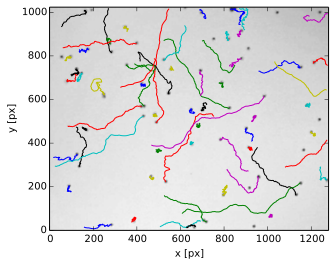

In [28]:
trajectory_plot = tp.plot_traj(t1, superimpose = frames[0], label=False)

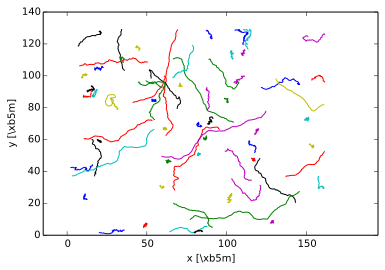

In [29]:
try:
    axes().set_aspect('equal', 'datalim') 
except:
    pass
trajectory_plot = tp.plot_traj(t1, mpp=scaling)

#savefig()

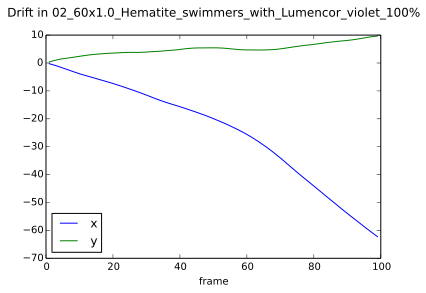

In [30]:
d = tp.compute_drift(t1, smoothing=15)

#plt.figure()
d.plot(grid=False)
plt.title('Drift in ' + moviename + '\n')